In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
sns.set(style='whitegrid',palette='husl')
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Texas School Cheating

### Read in the data (cfy03e3.csv and cfy04e4.csv)
When you're reading the data 
- set the 'campus' column to be the index 
- make sure to add suffix to each column based on the grade (3rd or 4th)

In [2]:
df = pd.read_csv("cfy03e3.csv").set_index('CAMPUS').add_suffix('_third')
df2 = pd.read_csv("cfy04e4.csv").set_index('CAMPUS').add_suffix('_fourth')

df.columns

Index(['DISTRICT_third', 'MONTH_third', 'YEAR_third', 'GRADE_third',
       'REGION_third', 'DNAME_third', 'CNAME_third', 'STATE_third',
       'a_docs_third', 'a_tst_n_third',
       ...
       'M_obj2_RI_third', 'M_obj3_NI_third', 'M_obj3_RI_third',
       'M_obj4_NI_third', 'M_obj4_RI_third', 'M_obj5_NI_third',
       'M_obj5_RI_third', 'M_obj6_NI_third', 'M_obj6_RI_third',
       'a_not_n_third'],
      dtype='object', length=1626)

## Join the datasets above horizontally

In [3]:
merged = df.join(df2)

In [4]:
merged.head(15)

,DISTRICT_third,MONTH_third,YEAR_third,GRADE_third,REGION_third,DNAME_third,CNAME_third,STATE_third,a_docs_third,a_tst_n_third,...,a_wc4_eco1_R_fourth,a_wc4_eco2_R_fourth,a_wc4_eco9_R_fourth,a_wc4_voce_R_fourth,a_wc4_vocs_R_fourth,a_wc4_vocp_R_fourth,a_wc4_ecoy_R_fourth,a_wc4_econ_R_fourth,a_wc4_ecov_R_fourth,a_not_n_fourth
CAMPUS,,,,,,,,,,,,,,,,,,,,,
1902103,1902,3,3,3,7,CAYUGA ISD,CAYUGA EL,1,41,36,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1903101,1903,4,3,3,7,ELKHART ISD,ELKHART EL,1,73,62,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1904102,1904,4,3,3,7,FRANKSTON ISD,FRANKSTON EL,1,70,64,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,6.0,NaN,NaN
1906102,1906,4,3,3,7,NECHES ISD,NECHES EL,1,17,14,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1907110,1907,4,3,3,7,PALESTINE ISD,STORY EL,1,262,246,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1908101,1908,4,3,3,7,WESTWOOD ISD,WESTWOOD EL,1,135,123,...,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1909101,1909,3,3,3,7,SLOCUM ISD,SLOCUM EL,1,25,23,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,33.0,NaN,NaN
2901101,2901,3,3,3,18,ANDREWS ISD,DEVONIAN ELEM,1,51,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2901103,2901,4,3,3,18,ANDREWS ISD,SAN ANDRES ELEM,1,52,49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Drop emty campus names for both grades

In [5]:
merged = merged.dropna(subset=['CNAME_third', 'CNAME_fourth'])
merged.shape

(3555, 3778)

## Plot the resulting DF using regplot in seaborn
for x use 'r_all_rs_third'
for y use 'r_all_rs_fourth'

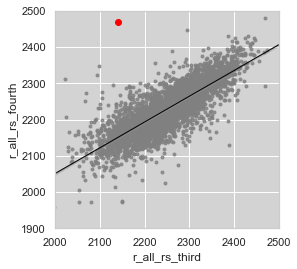

In [10]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set_xlim(2000, 2500)
ax.set_ylim(1900, 2500)
ax.set_facecolor('lightgrey')
ax.grid(True, color='white')
ax.set_axisbelow(True)

sns.regplot('r_all_rs_third',
            'r_all_rs_fourth',
            data=merged,
            marker='.', 
            line_kws={"color": "black", "linewidth": 1},
            scatter_kws={"color": "grey"})
harr = merged.loc[57905115]
plt.plot(harr.r_all_rs_third, harr.r_all_rs_fourth, 'ro')


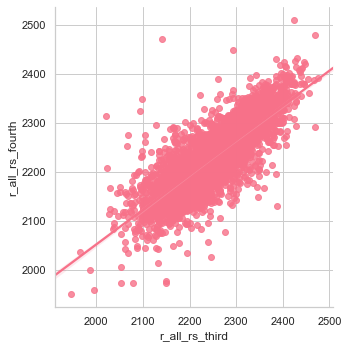

In [12]:
sns.lmplot(x='r_all_rs_third',y='r_all_rs_fourth',data=merged)

## Based on the graph above find the name of the outlier school

In [15]:
merged[(merged.r_all_rs_fourth > 2450) & (merged.r_all_rs_third < 2200)][['CNAME_third', 'r_all_rs_third', 'r_all_rs_fourth']]


,CNAME_third,r_all_rs_third,r_all_rs_fourth
CAMPUS,,,
57905115,HARRELL BUDD EL,2140.0,2470.0


## Try to predict 4th graders' scores based on their third grade performance using a linear regression
!!! Make sure both score columns have no null values

In [110]:
merged = merged[merged.r_all_rs_fourth.notnull() & merged.r_all_rs_third.notnull()]

# Fit a regression using sm.OLS(Y,X)
# With the intercept
X = merged[['r_all_rs_third']]
X = sm.add_constant(X)
mod = sm.OLS(merged.r_all_rs_fourth, X)
res = mod.fit()

## or without the intercept 
X = merged[['r_all_rs_third']]
mod = sm.OLS(merged.r_all_rs_fourth, X)
res = mod.fit()

## Print regression results using the .summary () method

In [111]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        r_all_rs_fourth   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          8.067e+06
Date:                Fri, 12 Jul 2019   Prob (F-statistic):                        0.00
Time:                        18:36:27   Log-Likelihood:                         -18403.
No. Observations:                3501   AIC:                                  3.681e+04
Df Residuals:                    3500   BIC:                                  3.681e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
r_all_rs_third     0.9905      0.000   2840.184      0.000       0.990       0.991
==============================================================================
Omnibus:                      363.602   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1604.827
Skew:                           0.420   Prob(JB):                         0.00
Kurtosis:                       6.209   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [112]:
res.params

r_all_rs_third    0.990451
dtype: float64

## If we would to predict the score of the 4th graders at HARRELL BUDD EL based on the results of 3rd graders?

In [114]:
res.predict([2140.0])

array([2119.56592325])

## How far is HARRELL BUDD EL score from the prediction

In [129]:
##Finidng standard deviation
#take the square root of (square the residuals and take the mean)
st_dev = np.sqrt(np.mean(res.resid**2))
st_dev

46.41737610431789

## Sort by how many standard deviations aways they are to find the CHEATERS

In [ ]:
#Compute the Standard Deviation of the data set
std_dev = np.sqrt(res.mse_resid)

In [ ]:
# Calculate standard deviation every school 
## In Stats terms: How spread out the points are around the line

merged['std_dev'] = res.resid / std_dev

In [ ]:
# Select only these columns ['CNAME_fourth', 'r_all_rs_fourth', 'r_all_rs_third', 'std_dev']
important_cols = merged[['CNAME_fourth', 'r_all_rs_fourth', 'r_all_rs_third', 'std_dev']]


In [136]:
# Then we'll sort by the standard deviation
# We want the top and the bottom, right? So we'll abs-value it?
std_dev_order = important_cols.std_dev.abs().sort_values(ascending=False).index
important_cols.reindex(std_dev_order)

,CNAME_fourth,r_all_rs_fourth,r_all_rs_third,std_dev
CAMPUS,,,,
57905115,HARRELL BUDD EL,2470.0,2140.0,7.548553
123803101,TEKOA ACADEMY O,2313.0,2021.0,6.705535
15803101,HIGGS/CARTER/KI,2349.0,2097.0,5.859543
101912172,HENDERSON N EL,2324.0,2093.0,5.406369
139908101,ROXTON EL,2130.0,2388.0,-5.066298
57825001,PINNACLE SCHOOL,2274.0,2068.0,4.862712
101823101,CHILDREN FIRST,2252.0,2066.0,4.431489
47905001,SIDNEY SCHOOL,2208.0,2024.0,4.379769
105802041,SAN MARCOS PREP,2025.0,2245.0,-4.277169
